In [41]:
!pip install colorama
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torchmetrics
import torch.nn.functional as F
import sys
from tqdm import tqdm
from colorama import Fore
from itertools import groupby
import numpy as np
import cv2
import requests
import os 
import zipfile
from urllib.parse import urlencode

In [43]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' #Ссылка на АПИ яндекса, чтобы скачать ваш архив
dataset_URL = "https://disk.yandex.ru/d/adjYzzNayB1pag" #Ссылка на ваш архив

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=dataset_URL))
response = requests.get(final_url)
download_url = response.json()['href']

# Загружаем файл и сохраняем его
if not os.path.exists("dataset.zip"):
    download_response = requests.get(download_url)
    with open('dataset.zip', 'wb') as f: 
        f.write(download_response.content)

# Распаковываем zip архив
if not os.path.exists("dataset"):     
    with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
        zip_ref.extractall('dataset')

In [44]:
def convert_letter_to_number(letter):
  if ord(letter) >=  ord('A') and  ord(letter) <= ord('Z'):
    return ord(letter) - ord('A')   
  
  return ord(letter) - ord('0') + 26

def convert_number_to_letter(number):
  if number > 25:
    return chr(number + ord('0') - 26)
  return chr(number + ord('A'))

def convert_string_to_array(string):
  res = []
  for letter in str(string):
    res.append(convert_letter_to_number(letter))

  return np.array(res)

def convert_array_to_string(array):
  res = []
  for number in array:
    res.append(convert_number_to_letter(number))

  return "".join(res)

In [45]:
print(convert_number_to_letter(0))
print(convert_letter_to_number('A'))

A
0


In [59]:
class Dataset(torch.utils.data.Dataset): #Класс считывающий датасет из папки
  def __init__(self, path_to_dir, resize = True):
    super(Dataset, self).__init__()
    self.items = np.array(os.listdir(path_to_dir))
    self.path_to_dir = path_to_dir
    self.clear_func = np.vectorize(self.clear_file_names)
    self.resize = resize

  @staticmethod
  def clear_file_names(dirty_name):
    return dirty_name[-10:-4]

  @staticmethod
  def resize_image(raw_image):
    return cv2.resize(raw_image, (120, 20))

  def __len__(self):
    return len(self.items)

  def __getitem__(self, idx):
    img_name = os.path.join(self.path_to_dir, self.items[idx])

    image = cv2.imdecode(np.fromfile(img_name, dtype=np.float32), cv2.IMREAD_UNCHANGED) #Голый cv2 не умеет читать файлы с киррилицей в пути. Поэтому делаем чере numpy -> cv2
    if self.resize:
      image = self.resize_image(image)
    image = image / 255

    image = np.mean(image, axis=2)

    label = self.clear_func(self.items[idx])
    return np.array(image).astype(np.float32), convert_string_to_array(label)
    

In [60]:
train_dataset = Dataset("dataset/CCPD2019-dl1/train")
test_dataset = Dataset("dataset/CCPD2019-dl1/test")

train_set, val_set = torch.utils.data.random_split(train_dataset,
                                                   [round(len(train_dataset) * 0.8), len(train_dataset) - round(len(train_dataset) * 0.8)])


train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=True)

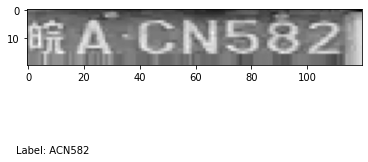

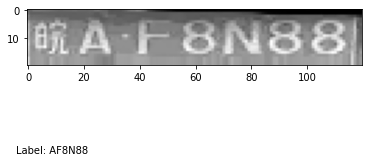

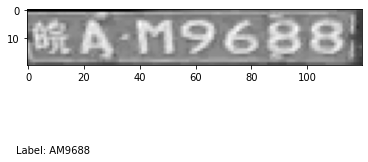

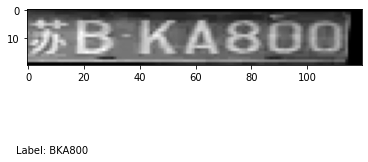

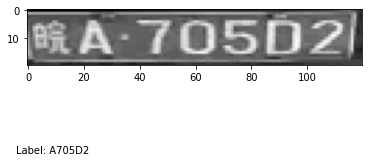

In [61]:
for j in np.random.randint(0, 5000, 5):
    plt.gcf().text(x=0.1, y=0.1, s="Label: " + convert_array_to_string(train_dataset[j][1]))
    plt.imshow(train_dataset[j][0], cmap='gray')
    plt.show()


In [62]:
class CRNN(torch.nn.Module):
    def __init__(self, gru_hidden_size = 128, gru_num_layers = 2, cnn_output_height = 4, cnn_output_width = 32, num_classes = 37):
        super(CRNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=(3, 3), padding='same')
        self.norm1 = torch.nn.InstanceNorm2d(32)
        self.conv2 = torch.nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2)
        self.norm2 = torch.nn.InstanceNorm2d(32)
        self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=(3, 3))
        self.norm3 = torch.nn.InstanceNorm2d(64)
        self.conv4 = torch.nn.Conv2d(64, 64, kernel_size=(3, 3), stride=2)
        self.norm4 = torch.nn.InstanceNorm2d(64)
        
        self.gru_input_size = cnn_output_height * 64
        self.gru = torch.nn.GRU(self.gru_input_size, gru_hidden_size, gru_num_layers, 
                          batch_first=True, bidirectional=True)
        self.fc = torch.nn.Linear(gru_hidden_size * 2, num_classes)

    def forward(self, x):
        batch_size = x.shape[0]
        out = self.conv1(x)
        out = self.norm1(out)
        out = F.leaky_relu(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = F.leaky_relu(out)
        out = self.conv3(out)
        out = self.norm3(out)
        out = F.leaky_relu(out)
        out = self.conv4(out)
        out = self.norm4(out)
        out = F.leaky_relu(out)
        out = out.reshape(batch_size, -1, self.gru_input_size)
        out, _ = self.gru(out)
        out = torch.stack([F.log_softmax(self.fc(out[i]), dim=-1) for i in range(out.shape[0])])
        return out


model = CRNN().to(torch.device('cuda'))
criterion = torch.nn.CTCLoss(blank=3, reduction='mean', zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
metric = torchmetrics.CharErrorRate()

In [ ]:
epochs = 10

for epoch in range(epochs):
    train_correct = 0
    train_total = 0
    train_cer = 0
    print(f"Epoch #{epoch}\n")
    for x_train, y_train in tqdm(train_loader,
                                 position=0, leave=True,
                                 file=sys.stdout, 
                                 bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.GREEN, Fore.RESET)):
        batch_size = x_train.shape[0]  
        x_train = x_train.view(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2])
        optimizer.zero_grad()
        y_pred = model(x_train.cuda())
        y_pred = y_pred.permute(1, 0, 2)  
        input_lengths = torch.IntTensor(batch_size).fill_(21)
        target_lengths = torch.IntTensor([len(t) for t in y_train])
        loss = criterion(y_pred, y_train, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()
        _, max_index = torch.max(y_pred, dim=2) 
        for i in range(batch_size):
            raw_prediction = list(max_index[:, i].detach().cpu().numpy()) 
            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != 36])
            if len(prediction) == len(y_train[i]) and torch.all(prediction.eq(y_train[i])):
                train_correct += 1
            train_total += 1
            train_cer += metric([convert_array_to_string(prediction.detach().cpu().numpy())],
                         [convert_array_to_string(y_train[i].detach().cpu().numpy())]).item()


    print('TRAINING. Accuracy: ', train_correct, '/', train_total, '=', train_correct / train_total)
    print('TRAINING. CER: ', train_cer, '/', train_total, '=', train_cer / train_total)


    val_correct = 0
    val_total = 0
    val_cer = 0
    for x_val, y_val in tqdm(val_loader,
                             position=0, leave=True,
                             file=sys.stdout, bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.BLUE, Fore.RESET)):
        batch_size = x_val.shape[0]
        x_val = x_val.view(x_val.shape[0], 1, x_val.shape[1], x_val.shape[2])
        y_pred = model(x_val.cuda())
        y_pred = y_pred.permute(1, 0, 2)
        input_lengths = torch.IntTensor(batch_size).fill_(21)
        target_lengths = torch.IntTensor([len(t) for t in y_val])
        criterion(y_pred, y_val, input_lengths, target_lengths)
        _, max_index = torch.max(y_pred, dim=2)
        for i in range(batch_size):
            raw_prediction = list(max_index[:, i].detach().cpu().numpy())
            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != 36])
            if len(prediction) == len(y_val[i]) and torch.all(prediction.eq(y_val[i])):
                val_correct += 1
            val_total += 1
            val_cer += metric([convert_array_to_string(prediction.detach().cpu().numpy())],
                         [convert_array_to_string(y_val[i].detach().cpu().numpy())]).item()

    print('TESTING. Accuracy: ', val_correct, '/', val_total, '=', val_correct / val_total)
    print('TESTING. CER: ', val_cer, '/', val_total, '=', val_cer / val_total)



Epoch #0

100%|██████████| 2500/2500 [04:08<00:00, 10.07it/s]
TRAINING. Accuracy:  88 / 159984 = 0.00055005500550055
TRAINING. CER:  61462.00118845701 / 159984 = 0.38417592502035836
100%|██████████| 39996/39996 [02:27<00:00, 270.60it/s]
TESTING. Accuracy:  15 / 39996 = 0.000375037503750375
TESTING. CER:  13805.833680480719 / 39996 = 0.34518036004802277
Epoch #1

100%|██████████| 2500/2500 [04:09<00:00, 10.04it/s]
TRAINING. Accuracy:  86 / 159984 = 0.0005375537553755376
TRAINING. CER:  55302.001386508346 / 159984 = 0.3456720758732645
100%|██████████| 39996/39996 [02:24<00:00, 276.88it/s]
TESTING. Accuracy:  14 / 39996 = 0.00035003500350035
TESTING. CER:  13838.500345990062 / 39996 = 0.3459971083605876
Epoch #2

100%|██████████| 2500/2500 [04:07<00:00, 10.09it/s]
TRAINING. Accuracy:  93 / 159984 = 0.0005813081308130813
TRAINING. CER:  55146.50138773024 / 159984 = 0.34470010368368237
100%|██████████| 39996/39996 [02:25<00:00, 274.15it/s]
TESTING. Accuracy:  15 / 39996 = 0.0003750375037503

In [ ]:
number_of_test_imgs = 10
test_loader = torch.utils.data.DataLoader(val_set, batch_size=number_of_test_imgs, shuffle=True)
test_preds = []
(x_test, y_test) = next(iter(test_loader))
y_pred = model(x_test.view(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2]).cuda())
y_pred = y_pred.permute(1, 0, 2)
_, max_index = torch.max(y_pred, dim=2)
for i in range(x_test.shape[0]):
    raw_prediction = list(max_index[:, i].detach().cpu().numpy())
    prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != 36])
    test_preds.append(prediction)

for j in range(len(x_test)):
    plt.imshow(x_test[j], cmap='gray')
    plt.gcf().text(x=0.1, y=0.1, s="Actual: " + convert_array_to_string(y_test[j].numpy()))
    plt.gcf().text(x=0.1, y=0.2, s="Predicted: " + convert_array_to_string(test_preds[j].numpy()))
    plt.show()